# Recommendation Systems for IBM Watson Studio platform

In this project, we analyze the interactions that users have with articles on the IBM Watson Studio platform, and make recommendations to them about new articles.

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>


Let's get started by importing the necessary libraries and reading in the data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv('user-item-interactions.csv')
df_content = pd.read_csv('articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [35]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

let's provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?   

In [36]:
# Descriptive statistics for user's interacts with articles
User_interacts = df.groupby(by="email").article_id.count()
User_interacts.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

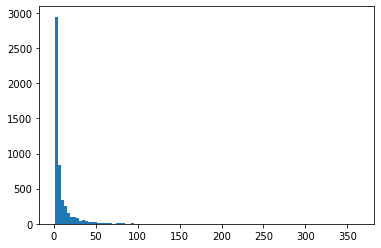

In [37]:
# Histogram plot for user's interaction with articles
plt.hist(User_interacts, bins =100);

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [38]:
# Find and explore duplicate articles
df_content[df_content["article_id"].duplicated(keep=False)]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [39]:
# Remove any rows that have the same article_id; only keep the first one 
df_content_UN = df_content.drop_duplicates(subset = ["article_id"], keep="first")
# Check the dataset to see if there is still duplicated values
df_content_UN["article_id"].duplicated(keep=False).sum()

0

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [40]:
# Specify the number of unique articles that have an interaction with a user.
print("unique_articles: {}".format(df.article_id.nunique()))

# Specify the number of unique articles in the dataset (whether they have any interactions or not).
print("total_articles: {}".format(df_content_UN.article_id.nunique()))

# Specify the number of unique users in the dataset. (excluding null values).
print("unique_users: {}".format(df.email.nunique()))

# Specify the number of user-article interactions in the dataset.
print("user_article_interactions: {}".format(df.shape[0]))

# Specify the most viewed article and number of reviews in the dataset.
most_viewed = df.groupby(by="article_id").count().title.sort_values(ascending = False).head(1);
print("the most viewed article and number of reviews are as follows: \n {}".format(most_viewed))

unique_articles: 714
total_articles: 1051
unique_users: 5148
user_article_interactions: 45993
the most viewed article and number of reviews are as follows: 
 article_id
1429.0    937
Name: title, dtype: int64


In [41]:
# Run this cell to map the user email to a user_id column and remove the email column
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded


In [42]:
# Show df to get an idea of the data
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this step, we find the most popular articles based on the number of interactions. Since there are no ratings for any of the articles, we can assume the articles with the most interactions are the most popular. These are then the articles we can recommend to new users.


In [43]:
# Return the 5 top articles ordered with most interactions. 
df.title.value_counts().sort_values(ascending=False).head()

use deep learning for image classification                      937
insights from new york car accident reports                     927
visualize car data with brunel                                  671
use xgboost, scikit-learn & ibm watson machine learning apis    643
predicting churn with the spss random tree algorithm            627
Name: title, dtype: int64

In [44]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.title.value_counts().sort_values(ascending=False).head(n).index.tolist()
    return top_articles 

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_article_ids - (list) A list ids for the top 'n' articles
    
    '''
    top_article_ids = df.article_id.value_counts().sort_values(ascending=False).head(n).index.tolist()
    top_article_ids = [str(x) for x in top_article_ids]
    return top_article_ids

In [45]:
# Print tiltes and IDs for the top 10 articles 
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

In this step, we look at users that are similar in terms of the items they have interacted with. These items will be recommended to the similar users. This would be a step in the right direction towards more personal recommendations for the users. 

In [46]:
# create the user-article matrix with 1's and 0's
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    '''
    
    df_subset = df[["user_id", "article_id"]]
    df_subset["count"] = 1
    user_item = df_subset.groupby(by=["user_id", "article_id"])["count"].mean().unstack().fillna(0)
    return user_item 

user_item = create_user_item_matrix(df)

Following function takes a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned list does not contain the provided user_id, as we know that each user is similar to him/herself.

In [47]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    '''
    # compute similarity of each user to the provided user
    similarity_mat = user_item.dot(user_item.transpose())
    
    # remove the own user's id
    similarity_user = similarity_mat.loc[user_id,:].drop(index=user_id)
        
    # sort by similarity
    similarity_user = similarity_user.sort_values(ascending=False)
    
    # create list of just the ids
    most_similar_users = similarity_user.index.tolist()  
    
    # return a list of the users in order from most to least similar
    return most_similar_users 
        

In [48]:
# Do a spot check 
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


Following functions return the articles we would recommend to each user.

In [49]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    df_unique = df.drop_duplicates(subset="title")
    article_names = list(df_unique[df_unique.article_id.isin(article_ids)].title)
    
    # Return the article names associated with list of article ids
    return article_names 

def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''

    article_ids = user_item.columns[user_item.loc[user_id,:]==1].astype('str')
    article_names = get_article_names(article_ids)
    
    # return the ids and names
    return article_ids, article_names 
    
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs=[]
    list_similar_user = find_similar_users(user_id)
    user_seen_articles = set(get_user_articles(user_id)[0])
    for user in list_similar_user:   
        recs+=list(set(get_user_articles(user)[0])-user_seen_articles)
        if len(recs)>=m:
            recs=recs[0:m]
            break
    
    # return your recommendations for this user_id 
    return recs    

In [50]:
# Check Results
# Return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10)) 

['ml optimization using cognitive assistant',
 'analyze open data sets with pandas dataframes',
 'intents & examples for ibm watson conversation',
 'maximize oil company profits',
 'pixieapp for outlier detection',
 'how smart catalogs can turn the big data flood into an ocean of opportunity',
 'using brunel in ipython/jupyter notebooks',
 'fertility rate by country in total births per woman',
 'web picks (week of 4 september 2017)',
 'aspiring data scientists! start to learn statistics with these 6 books!']

Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.

* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m; we choose articles with the most total interactions before choosing those with fewer total interactions. This ranking will be obtained from the **top_articles** function we wrote earlier.

In [51]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
    '''
    user_iduser_interaction = pd.DataFrame(df.groupby('user_id')['article_id'].count())
    user_iduser_interaction.columns=["num_interactions"]
    
    # compute similarity of each user to the provided user
    similarity_mat = user_item.dot(user_item.transpose())
    similarity_user = pd.DataFrame(similarity_mat.loc[user_id,:])
    similarity_user.columns = ["similarity"]
    similarity_user["num_interactions"] = user_iduser_interaction
    
    # remove the own user's id
    similarity_user.drop(index=user_id, inplace=True)
    
    # sort by similarity
    neighbors_df = similarity_user.sort_values(by=["similarity","num_interactions"], ascending=False)    # create list of just the ids
    
    # Return the dataframe specified in the doc_string
    return neighbors_df 


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    seen_articles = get_user_articles(user_id, user_item)[0]
    
    # retrieve similar user lists
    neighbors_df = get_top_sorted_users(user_id, df, user_item)
    neighbors_list = neighbors_df.index.tolist()
    
    # loop through the users based on the closeness

    recs = np.array([])
    
    for user in neighbors_list:
        
        neighbor_seen_articles = get_user_articles(user, user_item)[0]
        
        # find the list of articles that are not seen by the user
        new_recs = np.setdiff1d(neighbor_seen_articles, seen_articles, assume_unique=True)
        
        # Update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        # If we have enough recommendations exit the loop     
        if len(recs) >= m:
            break
    
    recs = recs[:m].tolist()
    rec_names = get_article_names(recs, df=df)    
    
    return recs, rec_names
    

In [52]:
# Check the output
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0', '1085.0', '109.0', '1150.0', '1151.0', '1152.0', '1153.0', '1154.0', '1157.0', '1160.0']

The top 10 recommendations for user 20 are the following article names:
['airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark', 'tensorflow quick tips', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice reviews', 'using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: chicago listings']


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the project, we will use matrix factorization to make article recommendations to the users.


We use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.

In [56]:
# Calculate user item matrix
user_item_matrix = create_user_item_matrix(df)

# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

We will run the following loop to get an idead about the impact of number of latent features on the accuracy.

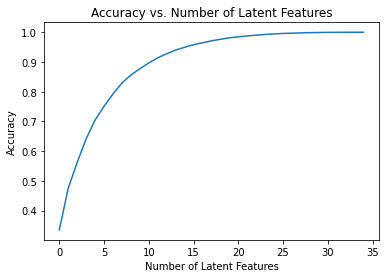

In [58]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

In [60]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)


Now we use the **user_item_train** dataset to find U, S, and V transpose using SVD. Then, determine the subset of rows in the **user_item_test** dataset that can be predict using the matrix decomposition with different numbers of latent features to see how many features makes sense to be keept based on the accuracy on the test data. 

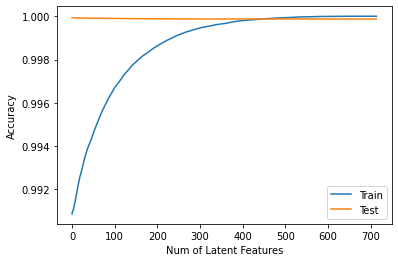

In [65]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

# Use these cells to see how well you can use the training 
# decomposition to predict on test data
test_rows = user_item_train.index.isin(test_idx)
test_columns = user_item_train.columns.isin(test_arts)
u_test = u_train[test_rows,:]
vt_test = vt_train[:,test_columns]

# Predict user_item_train and user_item_test using this matrix decomposition 
# with different numbers of latent features
train_error_list = []
test_error_list = []
for k in range(len(s_train)):
    
    # Reshape the matrix based on the num of latent features
    u_train_new, s_train_new, vt_train_new = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k,:]
    u_test_new, vt_test_new = u_test[:,:k], vt_test[:k, :]
    
    # Calculate the dot product
    estimated_user_item_train = np.round(np.dot(np.dot(u_train_new,s_train_new,),vt_train_new))
    estimated_user_item_test = np.round(np.dot(np.dot(u_test_new,s_train_new),vt_test_new))
    
    # Calculate the prediction error
    train_error = np.sum(np.sum(np.abs(np.subtract(user_item_train, estimated_user_item_train))))
    test_error = np.sum(np.sum(np.abs(np.subtract(user_item_test.loc[user_item_test.index[test_idx.isin(user_item_train.index)]], estimated_user_item_test))))
    
    # Append the calculate error to their respective lists
    train_error_list.append(train_error)
    test_error_list.append(test_error)

# Visualize the train and test error change with respect to num of latent features.
plt.plot(1 - np.array(train_error_list)/(user_item_train.shape[0]*user_item_train.shape[1]),label='Train');
plt.plot(1 - np.array(test_error_list)/(len(test_rows)*len(test_columns)),label='Test');
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Num of Latent Features");


The results show that by increasing the number of latent features, the accuracy of the prediction for the train set is increasing while the test accuracy is being reduced. This issue can be a result of having a few users in the test set who have recorded activities in the train set. Moreover, for the majority of the users in the test set, we could not implement collaborative filtering due to the cold start problem. So, for the newer users, we may implement rank-based or knowledge-based recommendation systems. 
Matrix factorization provides us with offline testing; however, sometimes this method is not applicable due to new users or contents. A practical approach for testing all introduced recommendation systems in this project can be A/B testing. we may implement the recommendation systems online and get feedback from users to determine whether the implemented recommendation system is helpful for the users or not.